<a href="https://colab.research.google.com/github/edramos-lab/StrawberriiesDetection/blob/main/notebooks/train-yolo11-object-detection-on-custom-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO11 Object Detection on a Custom Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Jan  8 05:09:38 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [6]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [7]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 33.7/235.7 GB disk)


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

## Custom Training

In [3]:
'''from google.colab import drive
drive.mount('/content/drive')'''
import kagglehub

# Download latest version
path = kagglehub.dataset_download("usmanafzaal/strawberry-disease-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 534M/534M [00:29<00:00, 18.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/usmanafzaal/strawberry-disease-detection-dataset/versions/1


In [4]:
# prompt: copy from '/root/.cache/kagglehub/datasets/usmanafzaal/strawberry-disease-detection-dataset/versions/1' to ./content

import os
import shutil

# Source and destination paths
source_dir = '/root/.cache/kagglehub/datasets/usmanafzaal/strawberry-disease-detection-dataset/versions/1'
destination_dir = './content'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy the contents of the source directory to the destination directory
try:
    shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)
    print(f"Successfully copied from '{source_dir}' to '{destination_dir}'")
except OSError as e:
    print(f"Error copying files: {e}")

Successfully copied from '/root/.cache/kagglehub/datasets/usmanafzaal/strawberry-disease-detection-dataset/versions/1' to './content'


In [8]:
import os
import json
from pathlib import Path
import kagglehub

# Download latest version

input_dir = Path(r"/content/content/train")
output_dir = input_dir / 'labels'  # YOLO labels will be saved in the 'labels' directory

# Create the 'labels' directory if it doesn't exist
output_dir.mkdir(parents=True, exist_ok=True)

# Define your class mapping (manually or by extracting from dataset)
class_mapping = {
    "Angular Leafspot": 0,
    "Anthracnose Fruit Rot": 1,
    "Blossom Blight": 2,
    "Gray Mold": 3,
    "Leaf Spot": 4,
    "Powdery Mildew Fruit": 5,
    "Powdery Mildew Leaf": 6,


}

# Function to normalize coordinates
def normalize(value, max_value):
    return value / max_value

# Iterate over all JSON files
for json_file in input_dir.glob("*.json"):
    with open(json_file, "r") as file:
        data = json.load(file)

    # Get image dimensions
    img_width = data["imageWidth"]
    img_height = data["imageHeight"]

    # YOLO label content
    yolo_labels = []

    for shape in data["shapes"]:
        class_name = shape["label"]  # Change this to map class names to class IDs
        points = shape["points"]

        # Normalize polygon points
        normalized_points = [
            (normalize(x, img_width), normalize(y, img_height)) for x, y in points
        ]
        flattened_points = [f"{x:.6f} {y:.6f}" for x, y in normalized_points]

        # Compute bounding box from the polygon
        x_coords = [p[0] for p in points]
        y_coords = [p[1] for p in points]
        x_min = max(min(x_coords), 0)
        y_min = max(min(y_coords), 0)
        x_max = min(max(x_coords), img_width)
        y_max = min(max(y_coords), img_height)

        # Convert to YOLO format
        x_center = normalize((x_min + x_max) / 2, img_width)
        y_center = normalize((y_min + y_max) / 2, img_height)
        width = normalize(x_max - x_min, img_width)
        height = normalize(y_max - y_min, img_height)

        # Add label in YOLOv11-Seg format
        # Map the class name to a class ID
        if class_name in class_mapping:
            class_id = class_mapping[class_name]
        else:
            raise ValueError(f"Unknown class '{class_name}' found in {json_file.name}. Please update the class_mapping.")
        yolo_labels.append(
            f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f} " +
            " ".join(flattened_points)
        )

    # Write YOLO label to file
    label_file = output_dir / (json_file.stem + ".txt")
    with open(label_file, "w") as file:
        file.write("\n".join(yolo_labels))

print("Conversion complete. YOLOv11-Seg labels saved!")



TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [9]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data=/content/drive/MyDrive/STRAW_DATASET/data1.yaml epochs=500 imgsz=640 plots=True batch=16 lr0=0.01 optimizer=AdamW

/content
New https://pypi.org/project/ultralytics/8.3.58 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/drive/MyDrive/STRAW_DATASET/data1.yaml, epochs=500, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_mas

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [5]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1736313204.061a309a1a58.1678.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


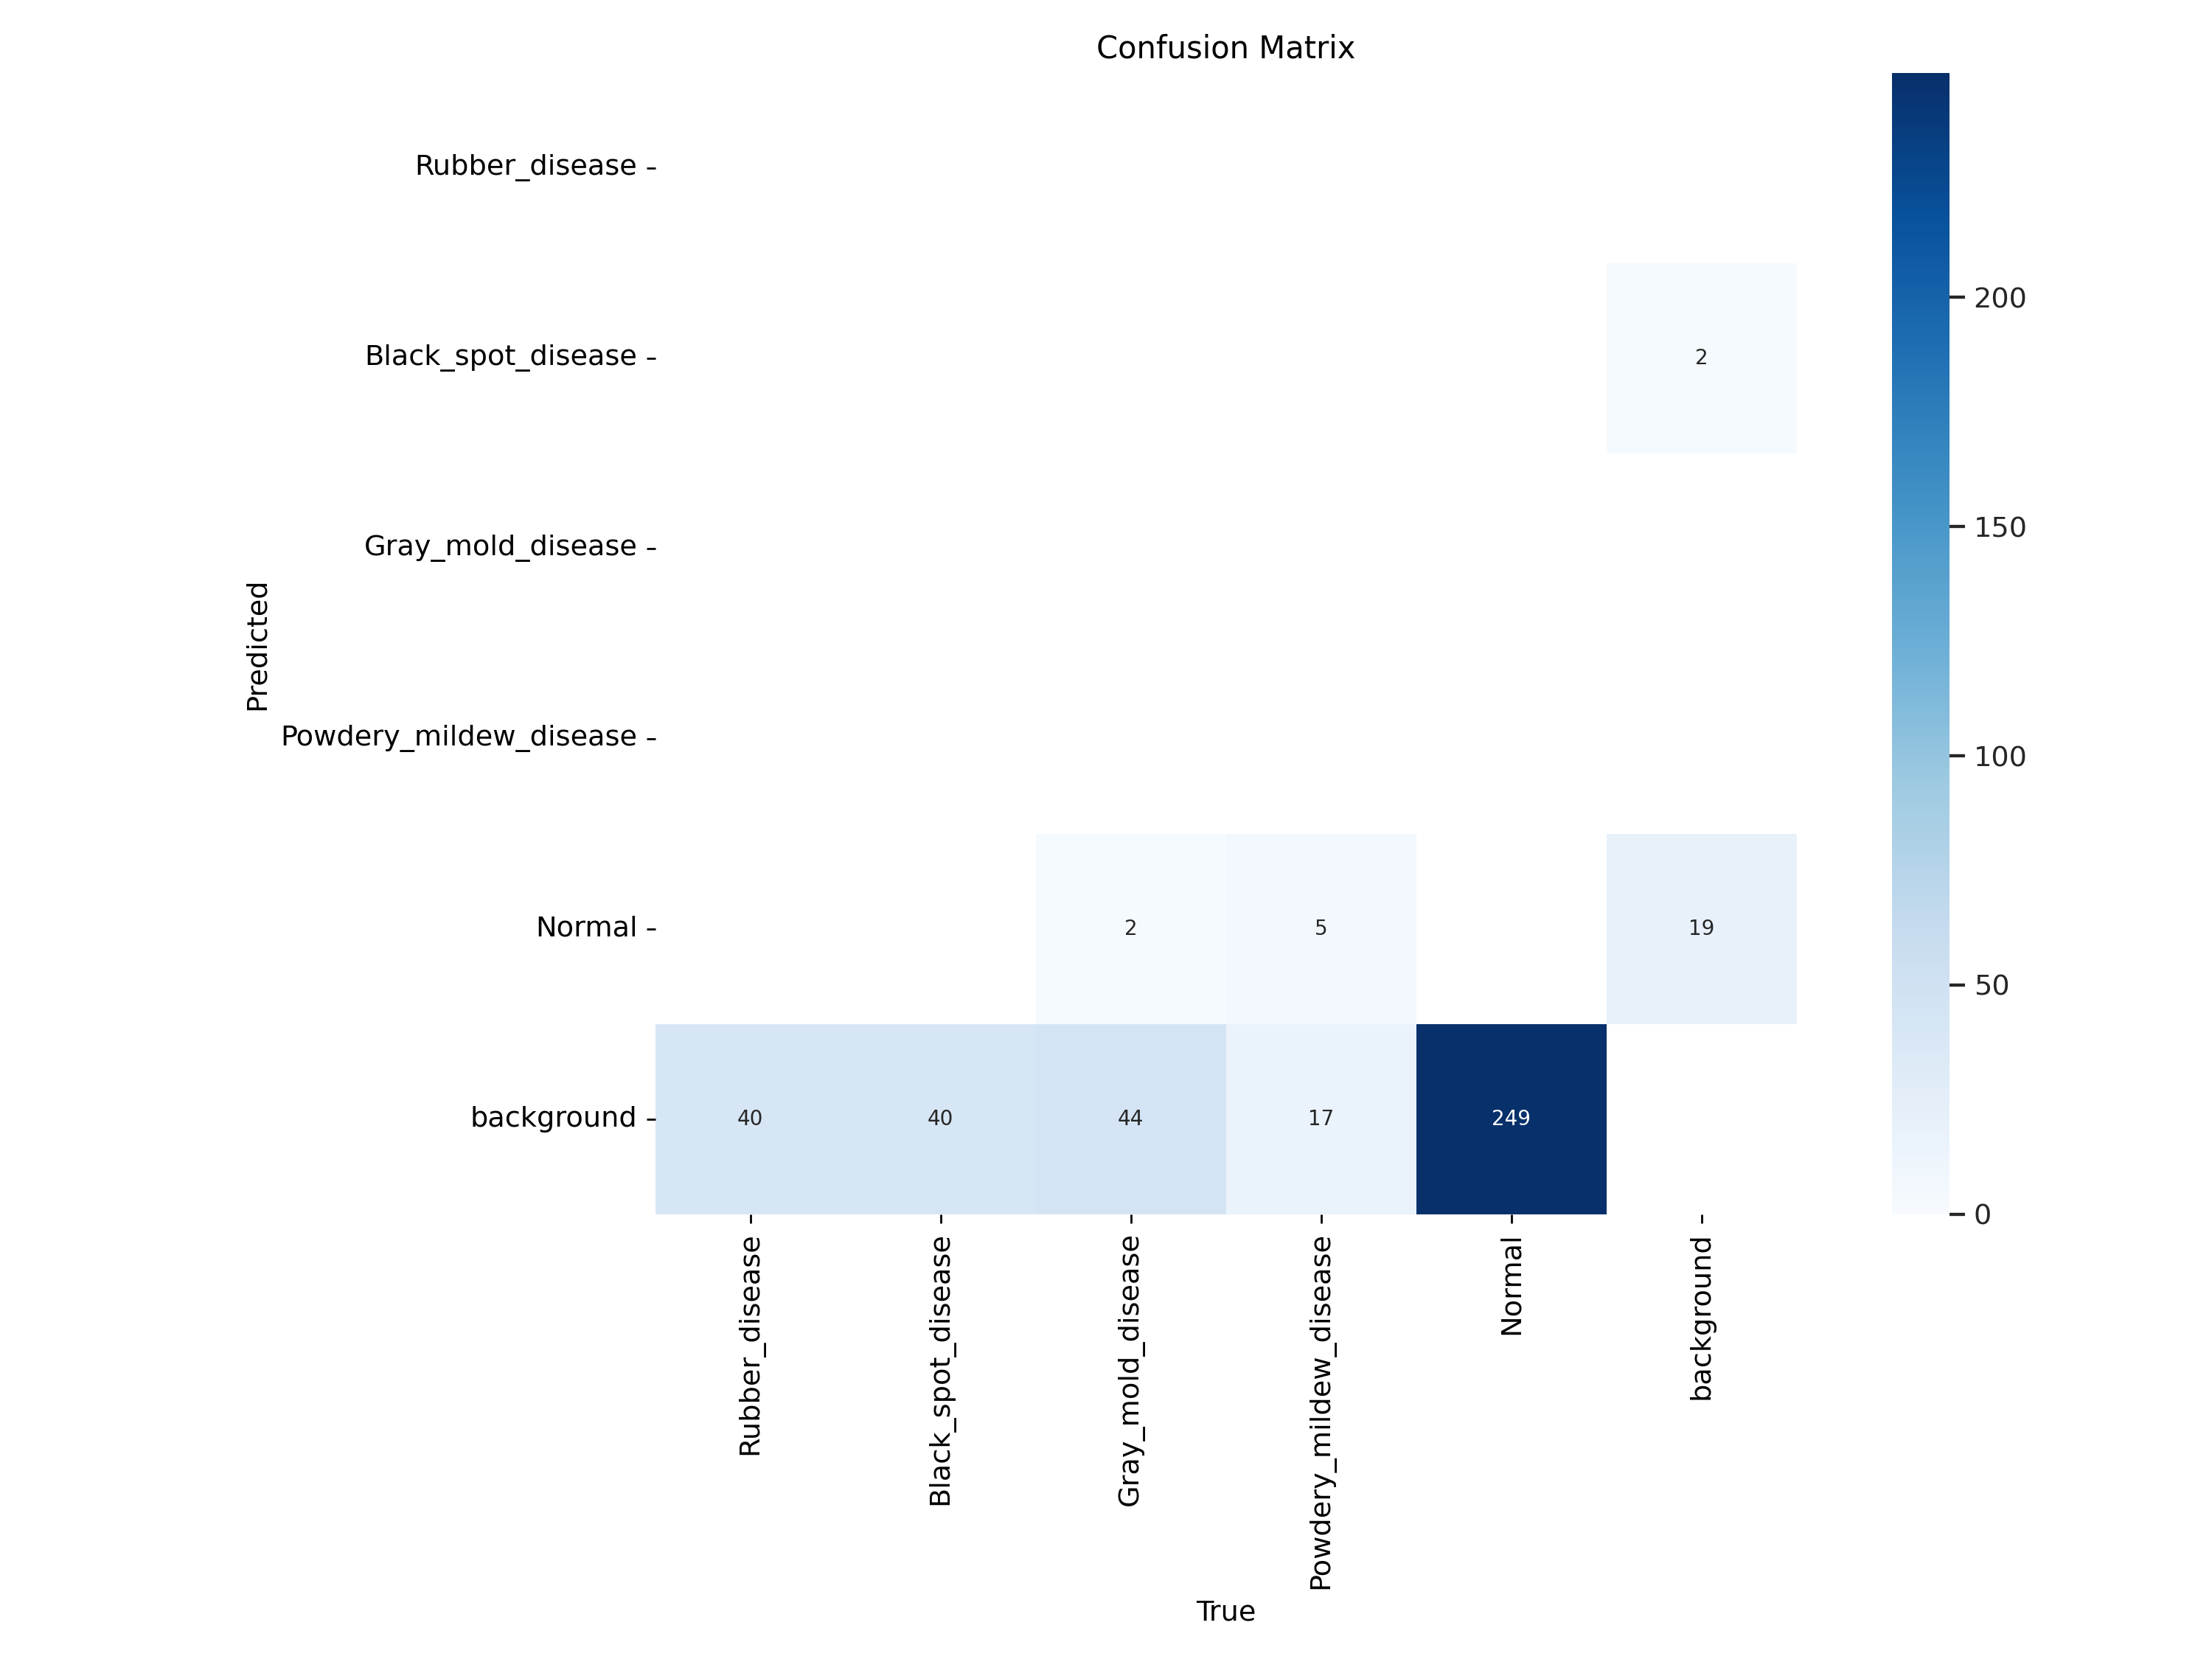

In [6]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

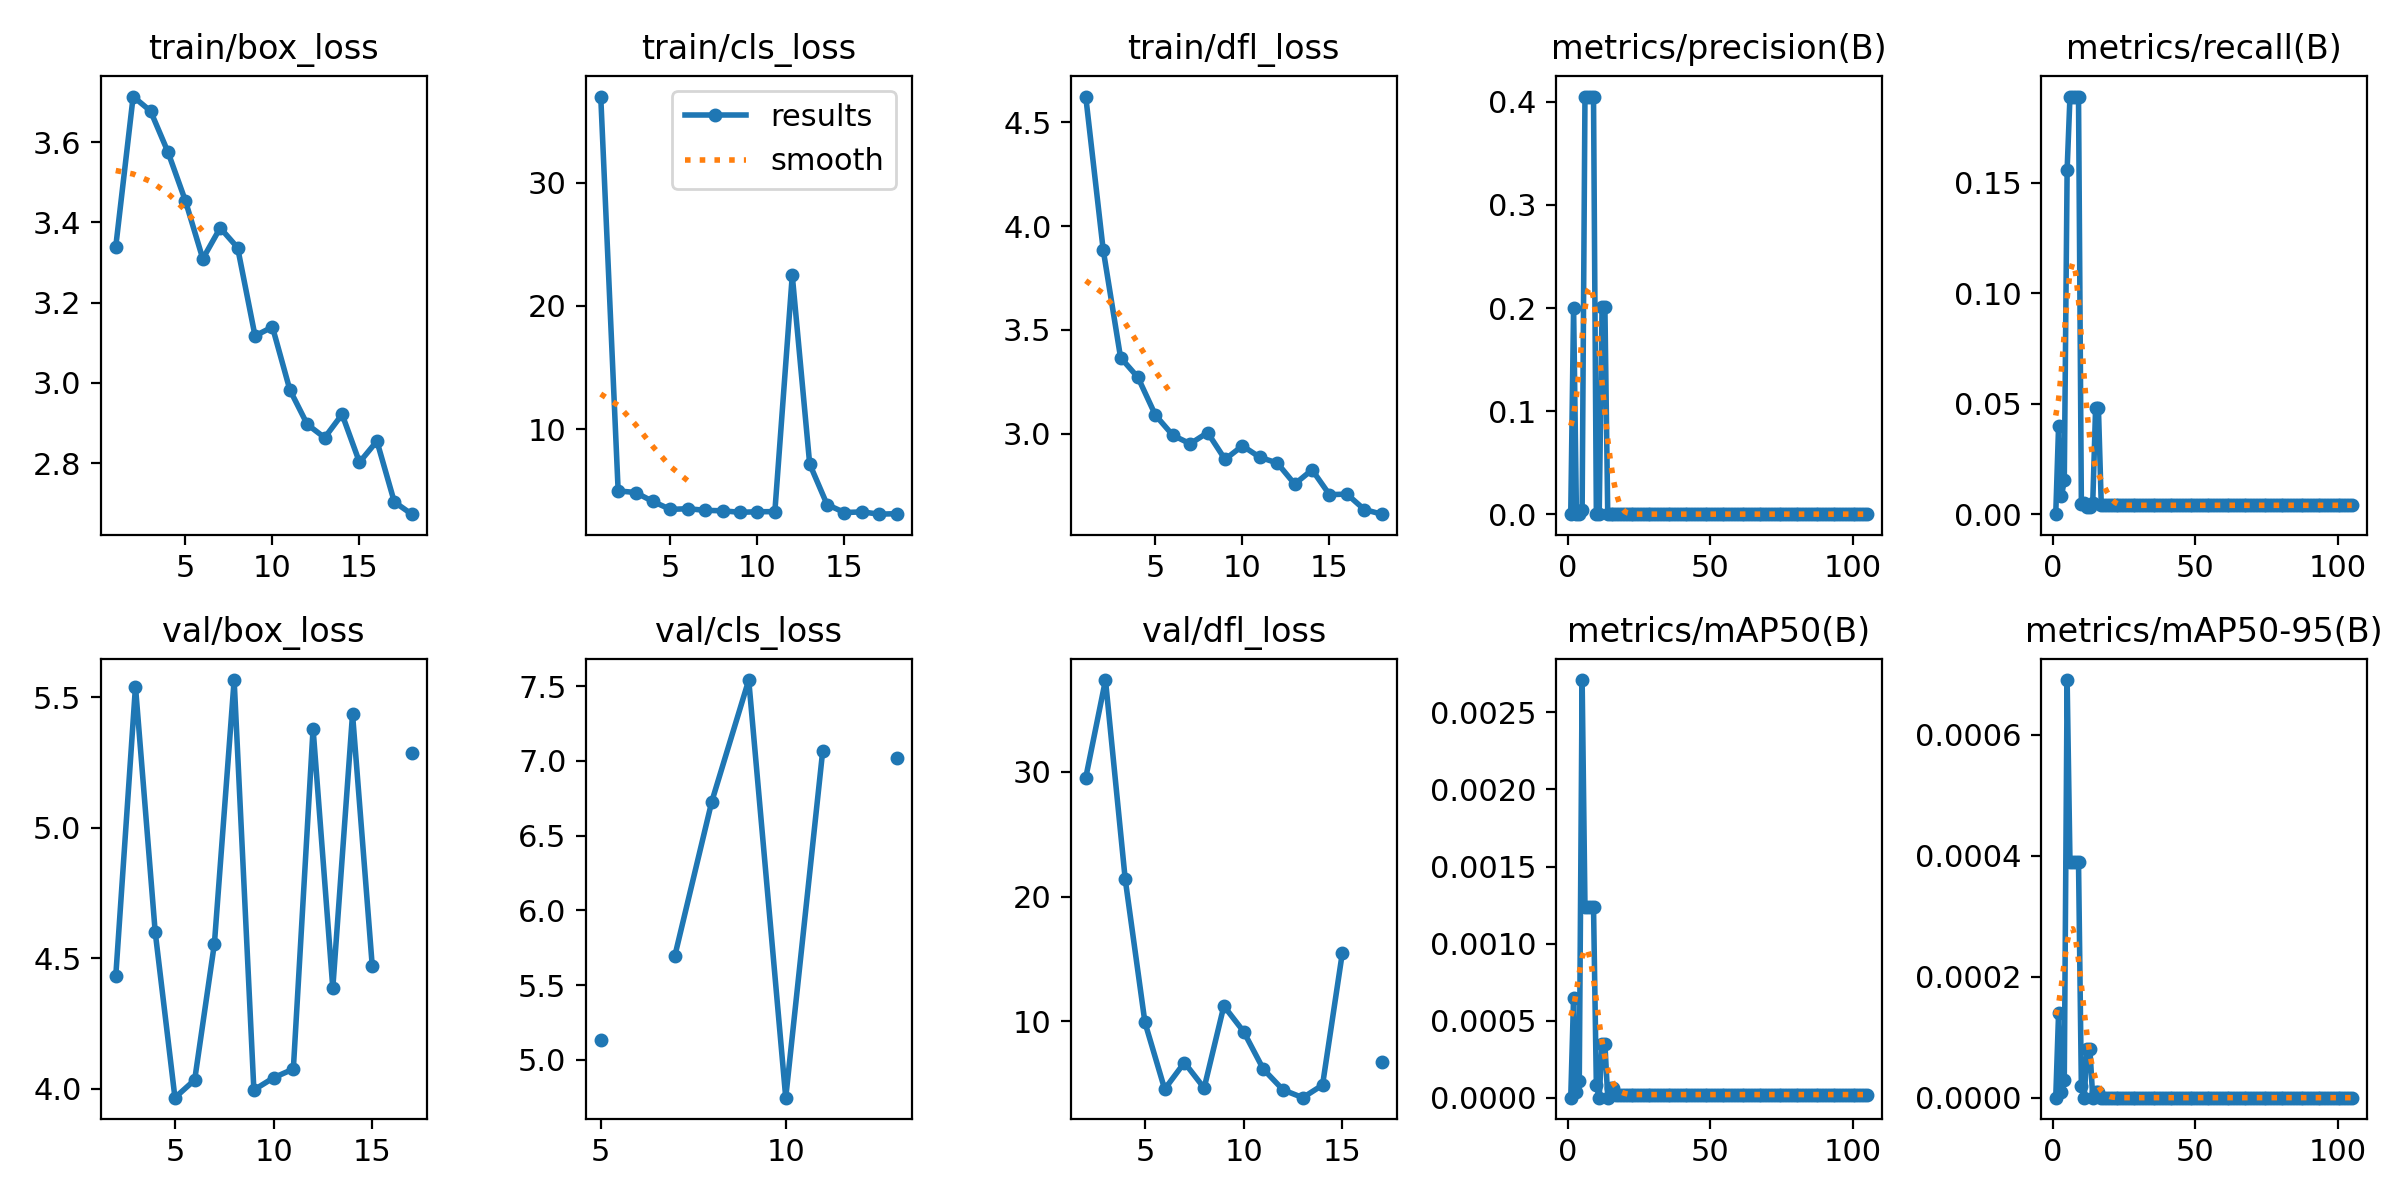

In [7]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

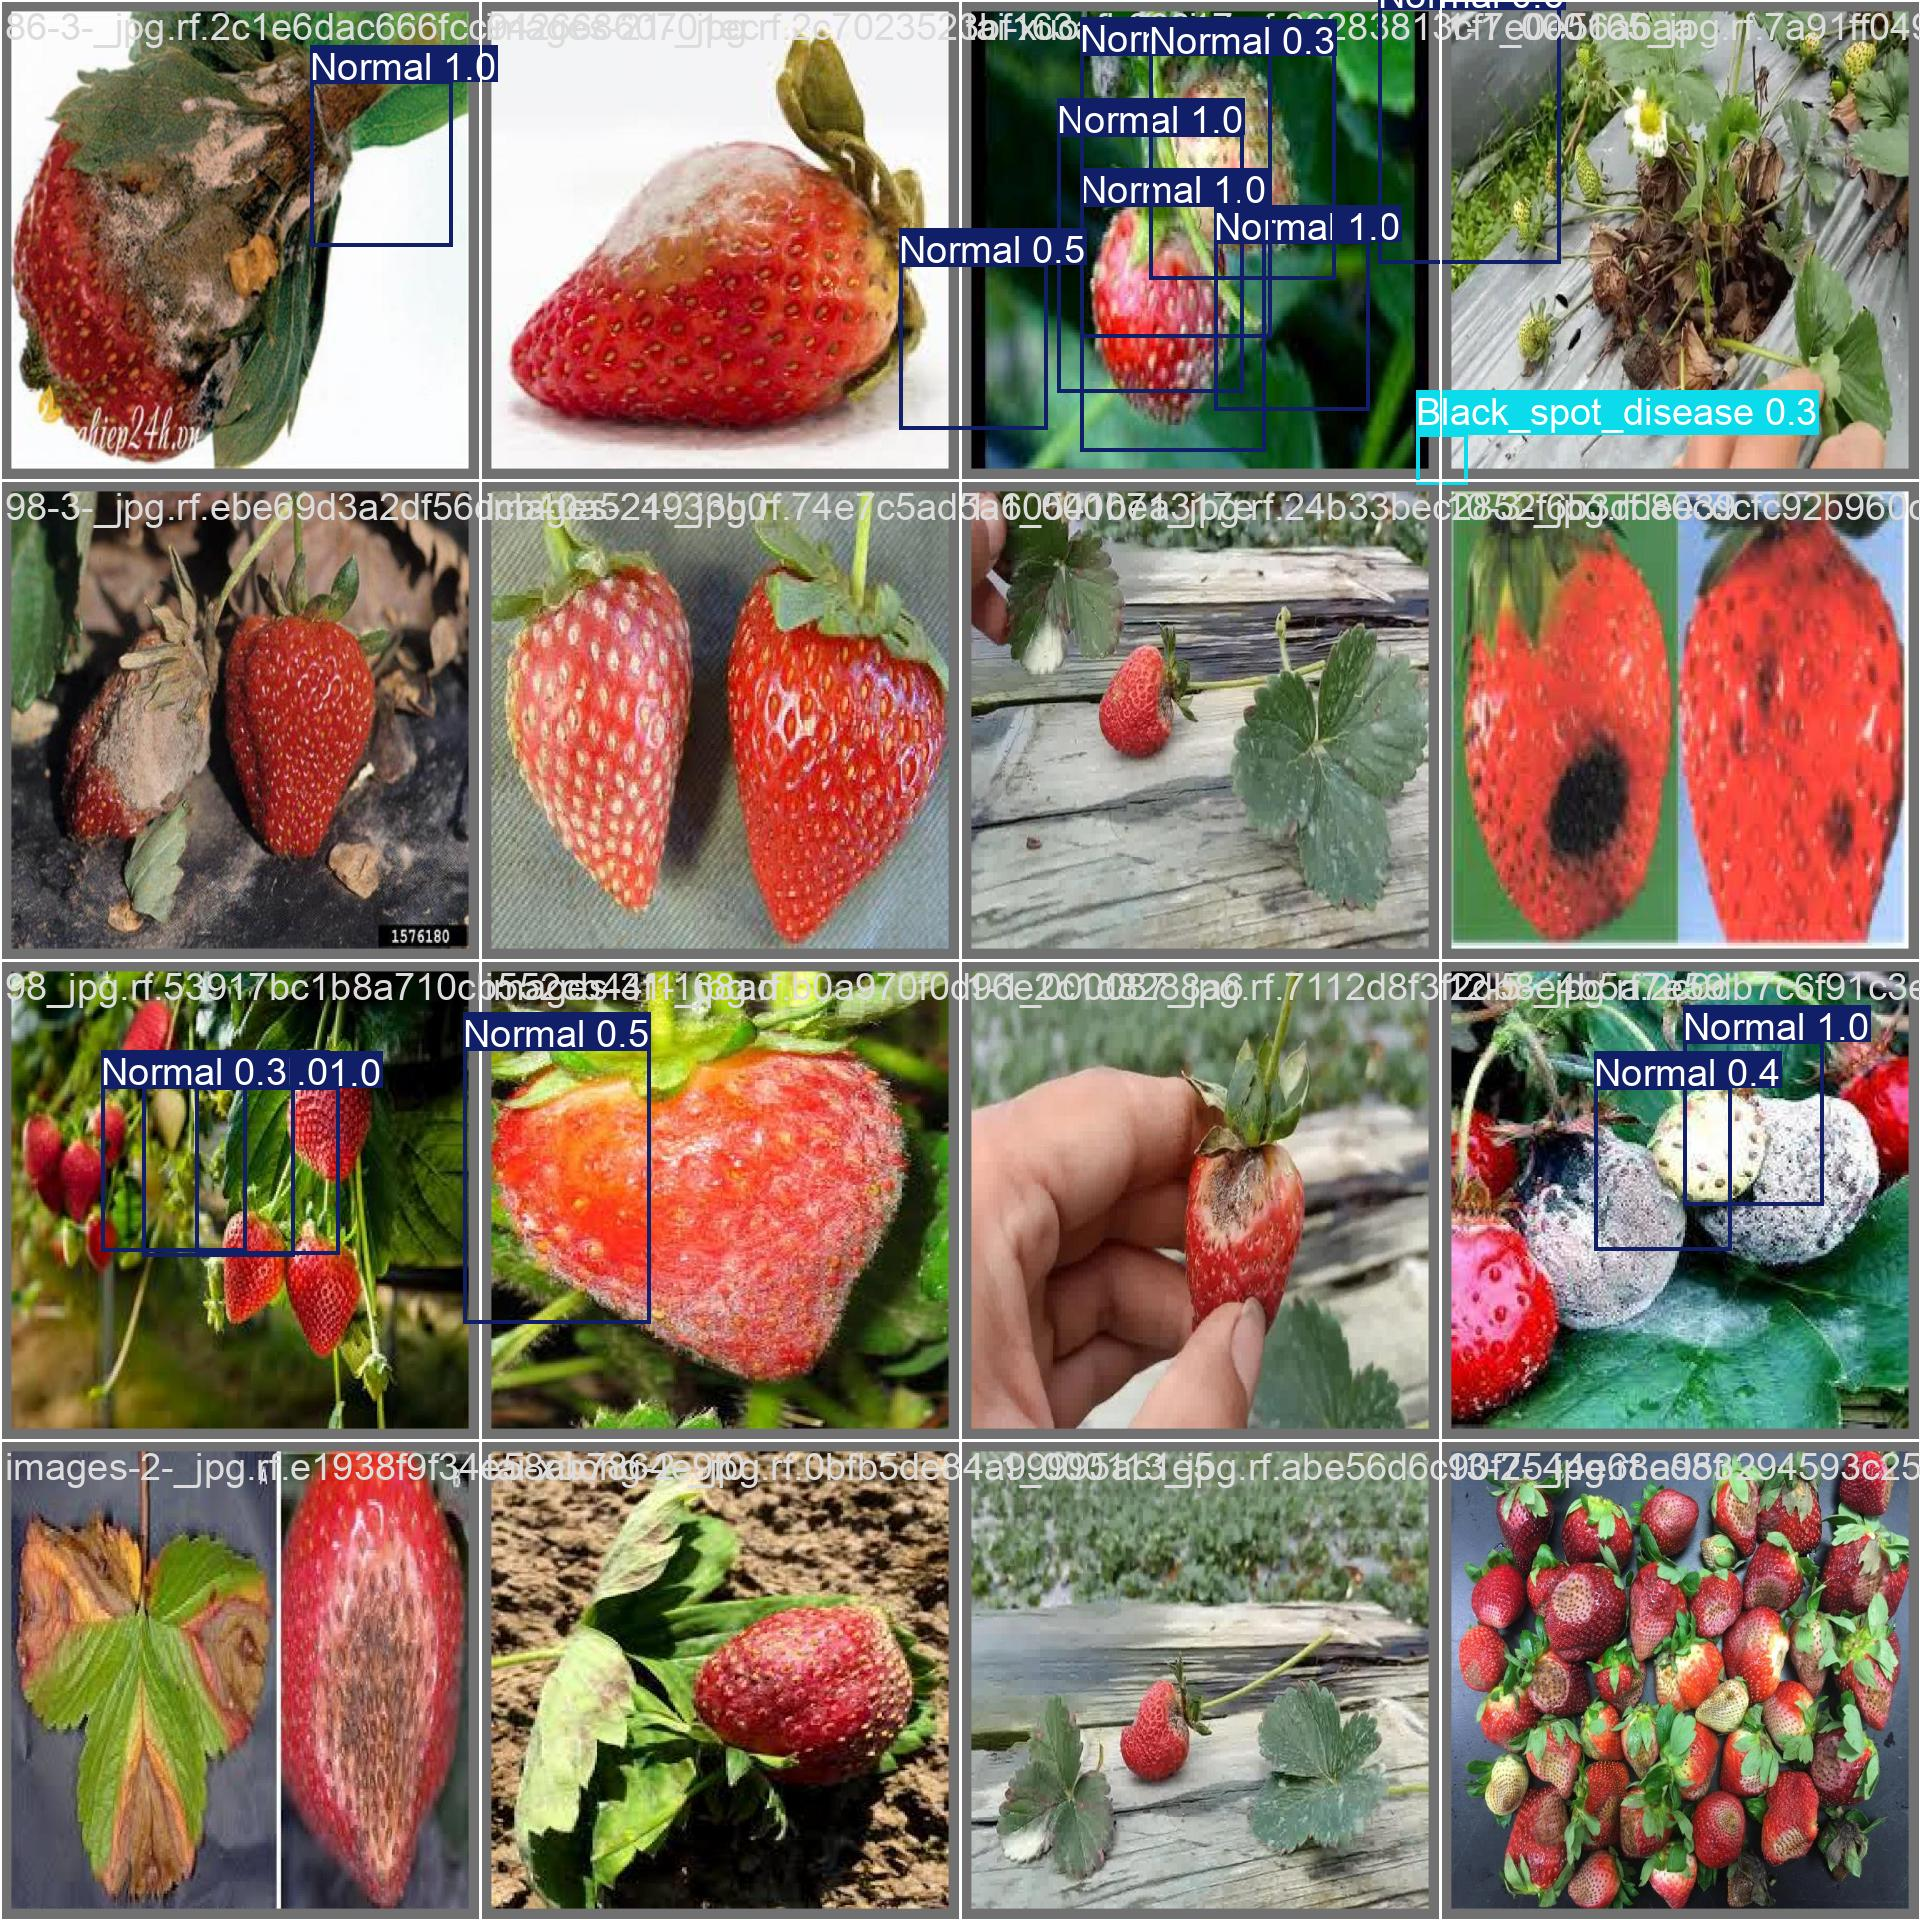

In [8]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [10]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data=/content/drive/MyDrive/STRAW_DATASET/data1.yaml

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11s summary (fused): 238 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/drive/.shortcut-targets-by-id/1JD2ERiYEHtRN3O2jSEJSx2Ws5_FPY6W4/STRAW_DATASET/valid/labels.cache... 81 images, 1 backgrounds, 0 corrupt: 100% 81/81 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 5, len(boxes) = 397. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:02<00:00,  2.20it/s]
                   all         81        397      0.772      0.664      0.781      0.543
        Rubber_disease          6         40       0.82      0.342      0.688      0.425
    Black_spot_disease         17         40      0.728      

## Inference with custom model

In [11]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source=/content/drive/MyDrive/STRAW_DATASET/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11s summary (fused): 238 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs

image 1/103 /content/drive/MyDrive/STRAW_DATASET/test/images/1-1_000063_jpg.rf.e46982b0dbbfa5e48876e57c31d318bf.jpg: 640x640 1 Black_spot_disease, 13.2ms
image 2/103 /content/drive/MyDrive/STRAW_DATASET/test/images/1-1_000067_jpg.rf.5e655fcd8307c3b3c4c9803febcdd540.jpg: 640x640 1 Black_spot_disease, 10.7ms
image 3/103 /content/drive/MyDrive/STRAW_DATASET/test/images/1-1_000084_jpg.rf.6811825946c0e410a2816452b13f3140.jpg: 640x640 1 Black_spot_disease, 11.0ms
image 4/103 /content/drive/MyDrive/STRAW_DATASET/test/images/1-1_000154_jpg.rf.573ac59b621a8c1fafa436f9956056bf.jpg: 640x640 2 Black_spot_diseases, 10.6ms
image 5/103 /content/drive/MyDrive/STRAW_DATASET/test/images/1-1_000156_jpg.rf.e307c330e076c6e65604828dbd995c3c.jpg: 640x640 2 Black_spot_diseases, 11.9ms
image 6/103 /content/drive/MyDrive/STRAW_DATASET

**NOTE:** Let's take a look at few results.

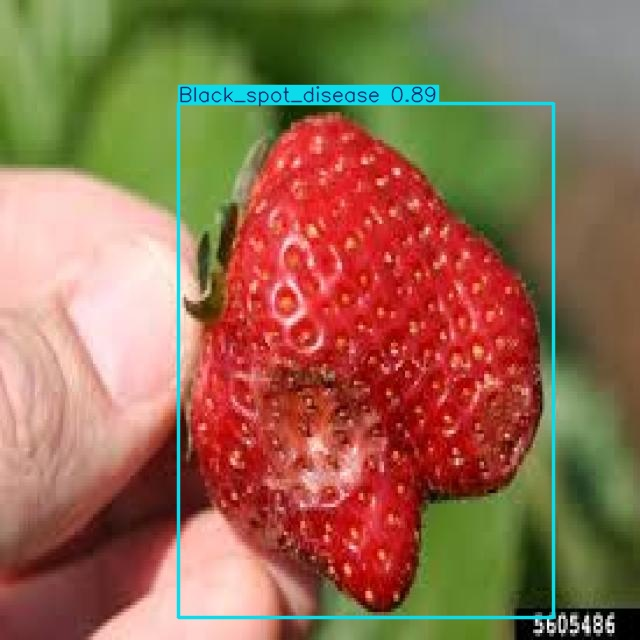

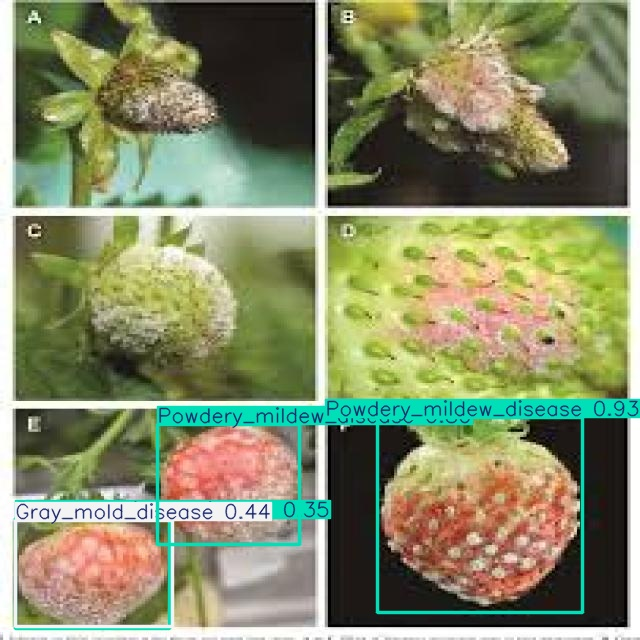

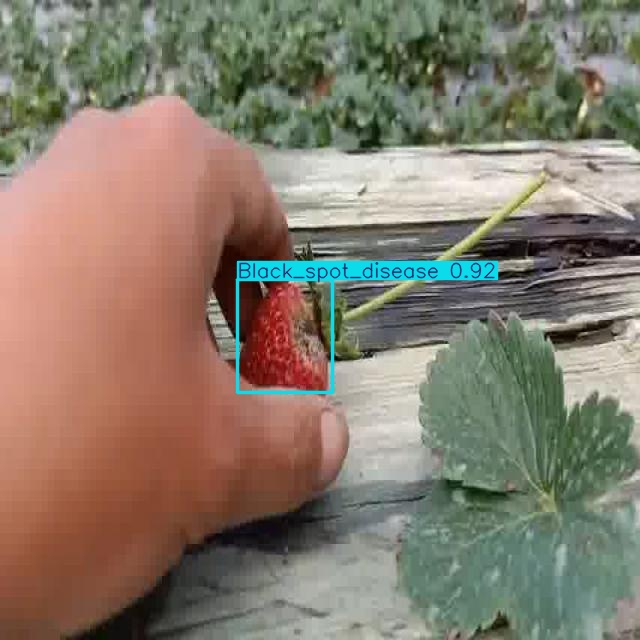

In [12]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [ ]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

In [ ]:
!pip install inference

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.